In [59]:
import argparse

parser = argparse.ArgumentParser(description='Process some integers.')
parser.add_argument('integers', metavar='N', type=int, nargs='+',
                    help='an integer for the accumulator')
parser.add_argument('--sum', dest='accumulate', action='store_const',
                    const=sum, default=max,
                    help='sum the integers (default: find the max)')

_StoreConstAction(option_strings=['--sum'], dest='accumulate', nargs=0, const=<built-in function sum>, default=<built-in function max>, type=None, choices=None, help='sum the integers (default: find the max)', metavar=None)

In [58]:
args = parser.parse_args()
print(args.accumulate(args.integers))

usage: ipykernel_launcher.py [-h] [--sum] N [N ...]
ipykernel_launcher.py: error: argument N: invalid int value: '/run/user/1001/jupyter/kernel-5c7097ba-953e-4fd6-9fb8-64d238c3618a.json'


SystemExit: 2

/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3273: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
#%load_ext autoreload
#%autoreload 2

In [2]:
from dfw.dfw import DFW
from dfw.dfw.losses import MultiClassHingeLoss
from dfw.experiments.utils import accuracy

In [51]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=256, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=10000, shuffle=True)

In [55]:
class SimpleCNN(nn.Module):
    """ A simple CNN """
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [20]:
model = SimpleCNN().cuda()

In [21]:
# boilerplate code:
# `model` is a nn.Module
# `x` is an input sample, `y` is a label

# create loss function
svm = MultiClassHingeLoss()

# create DFW optimizer with learning rate of 0.1
# does not work for eta = 0.1, 10000 batch, 10 epochs, cuda
# 20 epochs:still no
# 256 batch, 20 epochs: works

# works for cifar10 code python main.py --dataset cifar10 --densenet --opt dfw --l2 1e-4 --eta 0.1 --loss svm --smooth
# needed to download cifar10, install setup.py


# with rho = 0.1 slow
# with rho = 1 + modified update doesn't work
# with rho = 4 / (t + 8) ** (2/3)
r = lambda t : 4. / (t + 8) ** (2./3)
optimizer = DFW(model.parameters(), eta=0.1, rho_ = r)


# Adam worked for cuda, 10 epochs, 10000 batch size, 0.001 learning rate
# optimizer = optim.Adam(model.parameters(), lr=0.001)

In [54]:
def train(optimizer, model, train_loader, epochs = 15):
    """ Train the model using the optimizer on dataset train_loader for |epochs| """
    
    # batch losses
    losses = []
    
    # batch accuracies
    accs = []
    
    # training for epochs
    for epoch in range(epochs):
        # going over the dataset...
        for batch_idx, (x, y) in enumerate(train_loader):
            # DFW can be used with standard pytorch syntax
            x, y = x.cuda(), y.cuda()
            out = model(x)
            acc = accuracy(out, y)
            loss = svm(out, y)

            optimizer.zero_grad()
            loss.backward()

            # NB: DFW needs to have access to the current loss value,
            # (this syntax is compatible with standard pytorch optimizers too)
            optimizer.step(lambda: float(loss))
            losses.append(loss.item())
            accs.append(acc)
    return {'train_batch_losses': loses, 'train_batch_accs': accs}

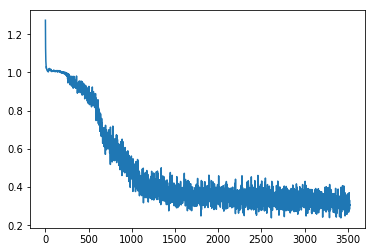

In [24]:
plt.plot(losses)

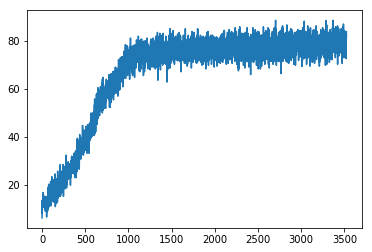

In [25]:
plt.plot(acc_train)

In [18]:
acc_train[-1]

tensor(90.6250, device='cuda:0')

In [32]:
def metrics_post(data_loader, model, name = ''):
    """ Compute metrics for a single model after training """
    
    # all accuracies 
    accs = []
    
    # all losses (will take mean)
    losses = []
    
    # going over the dataset
    for batch_idx, (x, y) in enumerate(data_loader):
        # DFW can be used with standard pytorch syntax
        x, y = x.cuda(), y.cuda()
        
        # model output
        out = model(x)
        
        # accuracy
        acc = accuracy(out, y)
        
        # loss
        loss = svm(out, y)
        
        accs.append(acc.item())
        losses.append(loss.item())
    return {name + 'accuracy': np.mean(accs), name + 'loss': np.mean(losses)}

In [42]:
def metrics_post_all(train_loader, test_loader, model):
    m_train = metrics_post(train_loader, model, name = 'train_')
    m_test = metrics_post(test_loader, model, name = 'test_')
    m_train.update(m_test)
    return m_train

In [52]:
metrics_post_all(train_loader, test_loader, model)

/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


{'train_accuracy': 82.18916223404256,
 'train_loss': 0.3145823466016891,
 'test_accuracy': 82.3699951171875,
 'test_loss': 0.31082668900489807}